In [44]:
#| code-fold: true
#| code-summary: Show supplementary code
from typing import Tuple, List, Any

from functools import partial

import numpy as np

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

from sklearn.manifold import TSNE

from jax.typing import ArrayLike
from jax.random import KeyArray
from jax.lax import scan
from jax import vmap
from jax import numpy as jnp
from jax import random, jit
from jax.scipy.linalg import inv

import matplotlib.pyplot as plt

@jit
def tempered_softmax(logits, temperature=1):
    """Produce a tempered softmax given logits.

    Args:
        logits (ArrayLike): logits to be turned into probability.
        temperature (int, optional): parameter controlling the softness
        of the function, the higher the value the more soft is the function. 
        Defaults to 1.

    Returns:
        ArrayLike: simplex derived from the input logits.
    """
    nominator = jnp.exp(logits / temperature)
    denominator = jnp.sum(nominator, axis=1).reshape(-1, 1)
    return nominator / denominator

# Premise

We want to stress how what is presented here is not at all novel but rather an exercise for leveraging the nice features that JAX offers and applying them for making the solution of a specific problem more efficient. Alot of credit for this post goes to the autohor of the original LinUCB paper, the contributors to the JAX library and to Kenneth Foo Fangwei for [this](https://kfoofw.github.io/contextual-bandits-linear-ucb-disjoint/) very clear blogpost explaining the fundamentals of the algorithm.

## What we will cover

1. Very brief introduction to multi armed and contextual multi armed bandit problems.
2. Very brief introduction to the LinUCB algorithm.
3. Simulating a disjoint contentual multi armed bandit problem.
4. Implementing the LinUCB algorithm in JAX.
5. Testing the algorithm on simulated data.
6. Accelerating testing and simulation using a GPU.
7. Evaluating the performance of the algorithm.

## What we will **not** cover

1. JAX fundamentals.
2. In depth expalantion of multi-armed and contextual multi-armed bandit problems.
3. In depth expalantion of the LinUCB algorithm.

# Introduction

## Multi-Armed Bandit Problem

The multi-armed bandit problem describes a situation where an agent is faced with $K = (k_0, k_1, \dots, k_n)$ different options (or arms), each one with an associated unknown payoff (or reward) $r_k$^[The assumption is that the payoff comes from a stationary distribution, meaning that at any point in time we can expect that $r_k \sim \mathcal{N}(\mu_k, \sigma_k)$ (or any other suitable probability distribution).] [@sutton2018reinforcement].

The goal of the agent is to select, over a finite sequence of interactions $T=(t_0, t_1, \dots, t_n)$, the set of options that will maximize the expected total payoff over $T$ [@sutton2018reinforcement]. What our agent is 
interested in then is the true value $q*$ of taking an action $a$ and selecting a given arm $k$, the action associated with highest value should be the go-to strategy for maximizing the cumulative payoff

Since the true value is not known, our agent often has to rely on an estimate of such value which comes with an associated level of uncertainity. We can think of this in terms of the relationship between the mean of the distribution from which the rewards of a given arm are sampled and its empirical estimate with associated standard error.

Selecting the best set of actions over a finite number of interactions then requires a balance between and **exploitative** and **explorative behaviour**

1. Exploit the options with the highest associated estimated reward 
2. Allow the exploration of other options in case our exploitative behaviour has been biased by noisy estimates. 

## Contextual Multi-Armed Bandit Problem

The conventional multi-armed bandit scenario attempts to solve what is called a nonassociative task, meaning that the payoff of a given action (e.g. selecting one of the $k$ available arms) doesn't depend on any context. This means that as a measure of value for a given action, we are interested in 

$\mathbb{E}[r | K=k]$

In a contextual multi-amred bandit scenario instead, the payoff of a given action is dependent on the context in which the action is performed. This implies that given a matrix of context vectors $X_{K\times h}$ we try to estimate the value of a given action as

$\mathbb{E}[r | K=k, X=x_k]$

In order to get a better understanding of what we mean here, let's simulate a potential generating process that could give rise to data suitable for a contextual multi-armed bandit problem.

### Create the Simulation Dataset

We will approximate the data generating process using sklearn's [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function. The idea is to re-formulate this as a multi-class classification problem where the context are features able to influece the probability to pick one of `n_arms` classes.

In order to simulate some of the challenges we could face in a real world setting we will add the following hurdles:

1. Only a small portion of the fetaures will actually have predictive power on which arm is the most promising.
2. We will generate features that have a ceertain degree of overlap (immagine them being drawn from relatively spread-out distributions)
3. We will enforce sparsity on the reward generated by each arm. This is like saying that the reward generated by pulling a given arm comes from a zero inflated distribution of the form

$$
hurdle \sim Bernoulli(p_{hurdle}) \\
P(r | K=k, X=x_k) = \alpha x_k \\
r = \begin{cases} 0,& \text{if hurdle} = 0 \\ Bernoulli(p_{r}),& \text{otherwise} \end{cases}
$$


In [45]:
UNIT_CONTEXT_SIZE = 1
UNIT_ARMS = 2

INFORMATIVE_RATIO = 2
REPEATED_RATIO = 0
REDUNDANT_RATIO = 0
RANDOM_RATIO = 256

REWARD_SPARSITY = 0.99
REWARD_WEIGHTING = 1 / (1 - REWARD_SPARSITY)

N_USERS = 1000

N_ARMS = UNIT_ARMS ** 2 # We ensure we can always plot the arms in a squared grid
CLASS_SEP = .9

INFORMATIVE = UNIT_CONTEXT_SIZE * INFORMATIVE_RATIO
REPEATED =  UNIT_CONTEXT_SIZE * REPEATED_RATIO
REDUNDANT =  UNIT_CONTEXT_SIZE * REDUNDANT_RATIO
RANDOM = UNIT_CONTEXT_SIZE * RANDOM_RATIO

CONTEXT_SIZE = INFORMATIVE + REPEATED + REDUNDANT + RANDOM

In [46]:
def generate_context(n_arms, n_users, context_size, redundant, repeated, informative, clusters_per_class, class_sep, with_intercept=True):
    context, groups = make_classification(
        n_classes=n_arms, 
        n_samples=n_users, 
        n_features=context_size,
        n_redundant=redundant,
        n_repeated=repeated,
        n_informative=informative,
        n_clusters_per_class=clusters_per_class,
        class_sep=class_sep
    )
    context = (context - context.mean(0)) / context.std(0)
    if with_intercept:

        context = np.hstack([context, np.ones(shape=(context.shape[0], 1))])
    
    return context, groups

def compute_arms_probabilities(context, groups, with_intercept=True, temperature=5):
    model = LogisticRegression(fit_intercept=not with_intercept).fit(context, groups)
    weights = model.coef_.T

    logits = context @ weights
    arms_probabilities = tempered_softmax(logits=logits, temperature=temperature)
    return arms_probabilities, model

def expand_context_to_arms(context, n_arms):
    context = np.array([context for _ in range(n_arms)])
    context = np.swapaxes(context, 0, 1)
    return context


CONTEXT, GROUPS = generate_context(
    n_arms=N_ARMS, 
    n_users=N_USERS, 
    context_size=CONTEXT_SIZE, 
    redundant=REDUNDANT, 
    repeated=REPEATED, 
    informative=INFORMATIVE, 
    clusters_per_class=1, 
    class_sep=CLASS_SEP, 
    with_intercept=True
)
ARMS_PROBAILITIES, MODE = compute_arms_probabilities(
    context=CONTEXT,
    groups=GROUPS,
    with_intercept=True,
)

CONTEXT = expand_context_to_arms(
    context=CONTEXT,
    n_arms=N_ARMS,
)

Here we will use TSNE for projecting the multidimensional context space on a 2D plane, this should allow us to get a better intuition of what is going on. What we expect to see are separate spheres or regions (this depends on how much noise we encode in our context space) with different colouring depening on which arms they are associated with


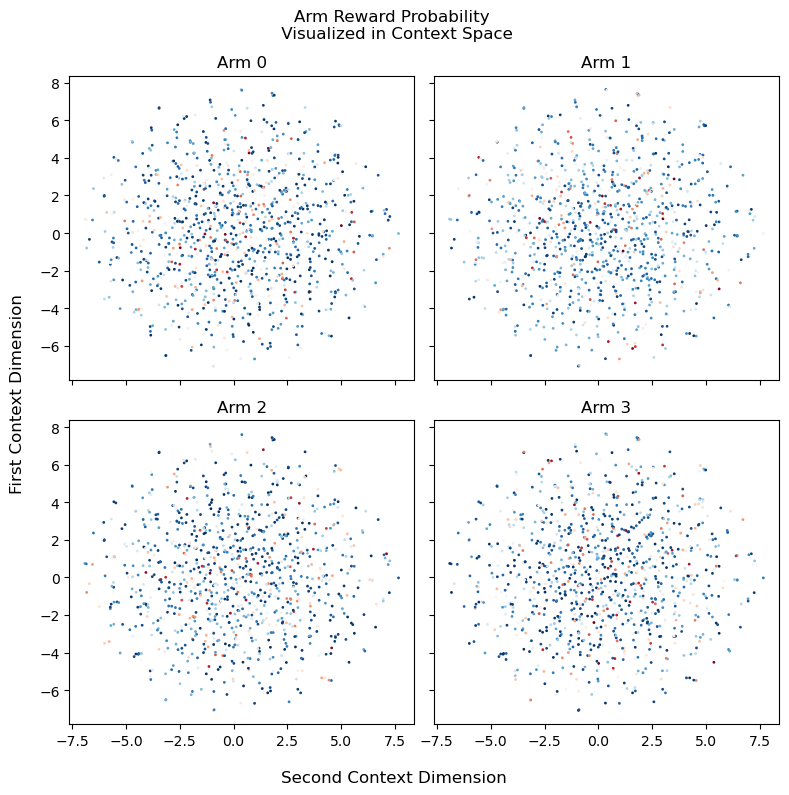

In [47]:
embedding = TSNE().fit_transform(CONTEXT[:, 0, :])

fig, axs = plt.subplots(UNIT_ARMS, UNIT_ARMS, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.flatten()
for arm in range(ARMS_PROBAILITIES.shape[1]):

    axs[arm].scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=ARMS_PROBAILITIES[:, arm],
        s=1,
        cmap="RdBu_r"
    )
    axs[arm].set_title(f"Arm {arm}")

fig.supylabel("First Context Dimension")
fig.supxlabel("Second Context Dimension")
fig.suptitle("Arm Reward Probability \n Visualized in Context Space")
plt.tight_layout()
plt.show()

## LinUCB Algorithm for a Multi-Armed Bandit Problem

# Implementing the Algorithm

## Parameters Initialisation


In [48]:
def init_matrices(context_size: int) -> Tuple[ArrayLike, ...]:
    A = jnp.eye(N=context_size)
    b = jnp.zeros(shape=(context_size, 1))
    return A, b

def init_matrices_for_all_arms(
        number_of_arms: int, 
        context_size: int,
    )  -> Tuple[ArrayLike, ...]:

    arms_A = []
    arms_b = []
    for _ in range(number_of_arms):

        A, b = init_matrices(context_size=context_size)
        arms_A.append(A)
        arms_b.append(b)

    arms_A = jnp.array(arms_A)
    arms_b = jnp.array(arms_b)

    return arms_A, arms_b

## Computations


In [49]:
@jit
def compute_theta(
        A_inverse: ArrayLike, 
        b: ArrayLike,
    ) -> ArrayLike:

    theta = jnp.dot(A_inverse, b)
    return theta

@jit
def compute_sigma(
        context: ArrayLike, 
        A_inverse: ArrayLike,
    ) -> ArrayLike:

    sigma = jnp.sqrt(
        jnp.dot(
            jnp.transpose(context), 
            jnp.dot(A_inverse, context)
        )
    )
    return sigma

@jit
def compute_mu(
        theta: ArrayLike, 
        context: ArrayLike,
    )-> ArrayLike:

    mu = jnp.dot(
        jnp.transpose(theta),
        context
    )
    return mu

@jit
def compute_upper_bound(
        A: ArrayLike, 
        b: ArrayLike, 
        context: ArrayLike, 
        alpha: float,
    ) -> ArrayLike:
    A_inverse = inv(A)
    context_column = jnp.reshape(a=context, newshape=(-1, 1))

    theta = compute_theta(
        A_inverse=A_inverse, 
        b=b
    )
    sigma = compute_sigma(
        context=context_column, 
        A_inverse=A_inverse
    )
    mu = compute_mu(
        theta=theta, 
        context=context_column
    )
    upper_bound = mu + (sigma * alpha)
    return upper_bound

@jit
def execute_linucb(
        alpha: float, 
        arms_A: ArrayLike, 
        arms_b:ArrayLike, 
        context: ArrayLike, 
        noise: ArrayLike,
    ) -> ArrayLike:
    partialized_compute_upper_bound = partial(
        compute_upper_bound,
        alpha=alpha
    )
    upper_bound = vmap(
        fun=vmap( 
            fun=partialized_compute_upper_bound, 
            in_axes=(0, 0, 0)
        ),
        in_axes=(None, None, 0)
    )(arms_A, arms_b, context).squeeze()
    upper_bound += noise
    return upper_bound

## Update parameters


In [50]:
@jit
def update_parameters(
    arms_A: ArrayLike, 
    arms_b: ArrayLike, 
    arms_context: ArrayLike, 
    policy: ArrayLike, 
    reward: ArrayLike
) -> Tuple[ArrayLike, ArrayLike]:
    new_A=arms_A[policy, :, :] 
    new_b=arms_b[policy, :, :]
    context=arms_context[policy, :]

    context_column = jnp.reshape(a=context, newshape=(-1, 1))
    new_A += jnp.dot(context_column, jnp.transpose(context_column))
    new_b += reward*context_column

    arms_A = arms_A.at[policy, :, :].set(new_A)
    arms_b = arms_b.at[policy, :, :].set(new_b)
    return arms_A, arms_b

# Definining the simulation steps


In [55]:
@jit
def step(
        policy: ArrayLike, 
        arms_probabilities: ArrayLike, 
        step_key: ArrayLike, 
        reward_sparsity: ArrayLike,
        reward_weighting: float,
    ) -> ArrayLike:
    sparsity_key, reward_key = random.split(step_key)
    rows = jnp.arange(start=arms_probabilities.shape[0])

    sparsity_factor = random.bernoulli(
        key=sparsity_key,
        p=1 - reward_sparsity,
        shape=(arms_probabilities.shape[0],),
    ) * 1
    rewards = random.bernoulli(
        key=reward_key,
        p=arms_probabilities[rows, policy]
    ) * 1
    return (rewards * sparsity_factor) * reward_weighting

@jit
def execute_policies(
        upper_bound: ArrayLike, 
        random_arm_key: ArrayLike,
    ) -> Tuple[ArrayLike, ArrayLike]:
    random_policy  = random.choice(
        key=random_arm_key, 
        a=jnp.arange(upper_bound.shape[1]),
        shape=(upper_bound.shape[0],)
    )
    linucb_policy = upper_bound.argmax(axis=1)
    return linucb_policy, random_policy

@jit
def compute_rewards(
        linucb_policy: ArrayLike, 
        random_policy: ArrayLike, 
        arms_probabilities: ArrayLike, 
        reward_sparsity: ArrayLike, 
        reward_weighting: float,
        step_key
    ) -> ArrayLike:
    arms_rewards = []
    for policy in [linucb_policy, random_policy]:

        rewards = step(
            policy=policy, 
            arms_probabilities=arms_probabilities, 
            reward_sparsity=reward_sparsity,
            reward_weighting=reward_weighting,
            step_key=step_key
        )
        arms_rewards.append(rewards)

    return arms_rewards

@jit
def compute_regrets(
        linucb_policy: ArrayLike, 
        random_policy: ArrayLike, 
        arms_probabilities: ArrayLike
    ) -> List[ArrayLike]:
    policies_regrets = []
    optimality = arms_probabilities.max(1)
    rows = jnp.arange(start=arms_probabilities.shape[0])
    for policy in [linucb_policy, random_policy]:

        regret = optimality - arms_probabilities[rows, policy]
        policies_regrets.append(regret)
    
    return policies_regrets

@jit
def simulate_interaction(
        carry: Tuple[ArrayLike, ...], 
        x: Any, 
        arms_probabilities: ArrayLike, 
        alpha: float, 
        reward_weighting: float,
        reward_sparsity: float
    ) -> Any:
    split_key, arms_A, arms_b, context = carry
    noise_key, random_arm_key, step_key, split_key = random.split(split_key, 4)  
    noise = random.normal(
        key=noise_key, 
        shape=(context.shape[0], arms_A.shape[0])
    ) * 1e-5

    upper_bound = execute_linucb(
        alpha=alpha, 
        arms_A=arms_A, 
        arms_b=arms_b, 
        context=context, 
        noise=noise,
    )
    linucb_policy, random_policy= execute_policies(
        upper_bound=upper_bound, 
        random_arm_key=random_arm_key
    )
    linucb_rewards, random_rewards = compute_rewards(
        linucb_policy=linucb_policy, 
        random_policy=random_policy, 
        arms_probabilities=arms_probabilities, 
        reward_sparsity=reward_sparsity,
        reward_weighting=reward_weighting,
        step_key=step_key
    )
    linucb_regrets, random_regrets = compute_regrets(
        linucb_policy=linucb_policy, 
        random_policy=random_policy, 
        arms_probabilities=arms_probabilities
    )

    arms_A, arms_b = vmap(
        fun=update_parameters, 
        in_axes=(None, None, 0, 0, 0)
    )(arms_A, arms_b, context, linucb_policy, linucb_rewards)
    arms_A = arms_A.mean(0)
    arms_b = arms_b.mean(0)

    new_carry = (split_key, arms_A, arms_b, context)
    diagnostics = {
        "parameters": {"A": arms_A, "b": arms_b},
        "policies": {
            "linucb": {"rewards": linucb_rewards, "regrets": linucb_regrets}, 
            "random": {"rewards": random_rewards, "regrets": random_regrets}
        }

    }

    return new_carry, diagnostics

# Running the simulation


In [56]:
SIMULATION_STEPS = (24 * 4) * 7

split_key = random.PRNGKey(666)
arms_A, arms_b = init_matrices_for_all_arms(
    number_of_arms=N_ARMS, 
    context_size=CONTEXT.shape[-1]
)

partialized_simulate_interaction = partial(
    simulate_interaction, 
    arms_probabilities=ARMS_PROBAILITIES, 
    alpha=1,
    reward_sparsity=REWARD_SPARSITY,
    reward_weighting=REWARD_WEIGHTING,
)
carry, diagnostics = scan(
    partialized_simulate_interaction, 
    init=(split_key, arms_A, arms_b, CONTEXT),
    xs=jnp.arange(SIMULATION_STEPS)
)

# Performance Visualisation


In [57]:
#| code-fold: true
#| code-summary: Show supplementary code
def compute_diagnostics_summaries(diagnostics):
    diagnostics_summaries = {}
    for policy, diagnositcs_dict in diagnostics.items():

        diagnostics_summaries[policy] = {}

        for diagnostic, value in diagnositcs_dict.items():

            cumsum_value = value.cumsum(0)

            diagnostics_summaries[policy][diagnostic] = {
                "mean": value.mean(1), 
                "upper_percentile": np.percentile(value, 2.5, axis=1), 
                "lower_percentile": np.percentile(value, 97.5, axis=1), 
                "cumsum_mean": cumsum_value.mean(1), 
                "cumsum_upper_percentile": np.percentile(cumsum_value, 2.5, axis=1),
                "cumsum_lower_percentile": np.percentile(cumsum_value, 97.5, axis=1)
            }
    return diagnostics_summaries
 
def plot_diagnositc(mean, lower_percentile, upper_percentile, ax, label):
    ax.plot(
        mean,
        label=label
    )
    ax.fill_between(
        x=np.arange(mean.shape[0]),
        y1=lower_percentile,
        y2=upper_percentile,
        alpha=0.25
    )
    return ax

def plot_all_diagnostics(diagnostics_summaries, figsize=(10, 20)):
    fig, axs = plt.subplots(
        nrows=2, 
        ncols=2, 
        figsize=figsize, 
        sharex=True
    )
    axs = axs.flatten()

    for policy in list(diagnostics_summaries.keys()):

        ax = plot_diagnositc(
            mean=diagnostics_summaries[policy]["rewards"]["mean"], 
            lower_percentile=diagnostics_summaries[policy]["rewards"]["upper_percentile"], 
            upper_percentile=diagnostics_summaries[policy]["rewards"]["lower_percentile"], 
            ax=axs[0], 
            label=policy
        )
        ax.set_ylabel("Reward")
        ax = plot_diagnositc(
            mean=diagnostics_summaries[policy]["rewards"]["cumsum_mean"], 
            lower_percentile=diagnostics_summaries[policy]["rewards"]["cumsum_upper_percentile"], 
            upper_percentile=diagnostics_summaries[policy]["rewards"]["cumsum_lower_percentile"], 
            ax=axs[1], 
            label=policy
        )
        ax.set_ylabel("Cumulative Reward")

        ax = plot_diagnositc(
            mean=diagnostics_summaries[policy]["regrets"]["mean"], 
            lower_percentile=diagnostics_summaries[policy]["regrets"]["upper_percentile"], 
            upper_percentile=diagnostics_summaries[policy]["regrets"]["lower_percentile"], 
            ax=axs[2], 
            label=policy
        )
        ax.set_ylabel("Regret")
        ax.set_xlabel("Simulation Step")
        
        ax = plot_diagnositc(
            mean=diagnostics_summaries[policy]["regrets"]["cumsum_mean"], 
            lower_percentile=diagnostics_summaries[policy]["regrets"]["cumsum_upper_percentile"], 
            upper_percentile=diagnostics_summaries[policy]["regrets"]["cumsum_lower_percentile"], 
            ax=axs[3], 
            label=policy
        )
        ax.set_ylabel("Cumulative Regret")
        ax.set_xlabel("Simulation Step")

    for ax in axs:

        ax.grid()
        ax.legend()
    
    return fig, axs

In [61]:
diagnostics["parameters"]["b"].shape

(672, 4, 259, 1)

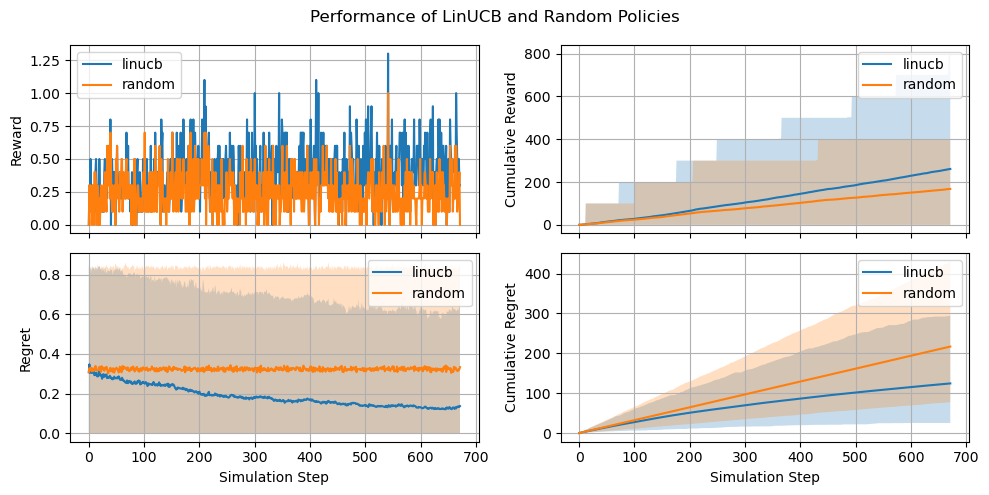

In [54]:
diagnostics_summaries = compute_diagnostics_summaries(
    diagnostics=diagnostics[]
)
fig, axs = plot_all_diagnostics(
    diagnostics_summaries=diagnostics_summaries, 
    figsize=(10, 5)
)
plt.suptitle("Performance of LinUCB and Random Policies")
plt.tight_layout()
plt.show()